In [18]:
import random
import numpy as np

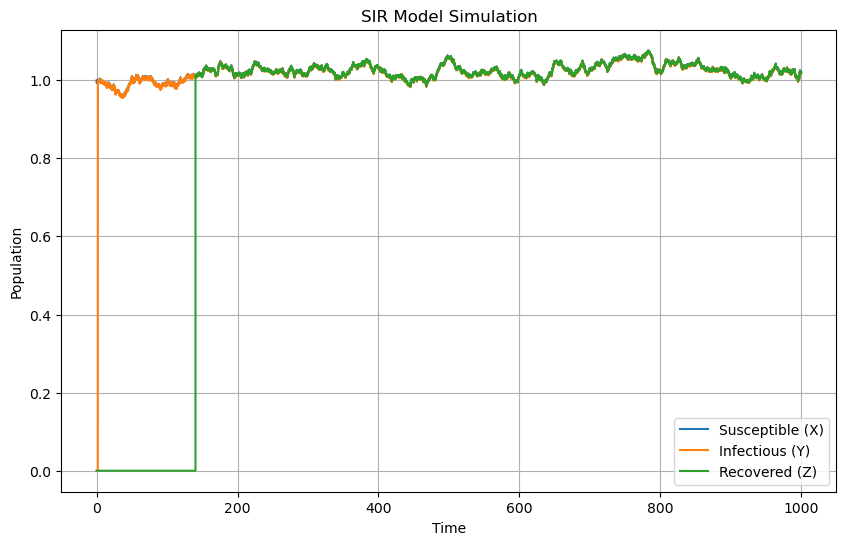

In [31]:
#Parameters and initial conditions
beta = 0.5
gamma = 0.3
mu = 0.01
N = 1000
infected_init = 1
recovered_init = 1

#Initialize compartments
X = N - infected_init - recovered_init
Y = infected_init
Z = recovered_init

#Define events
def Birth(X):
    X += 1
    return X

def GetInfected(X, Y):
    Y += 1
    X -= 1
    return X

def Recover(Y, Z):
    Y -= 1
    Z += 1
    return X

def DieSusceptibe(X):
    X -= 1
    return X

def DieInfected(Y):
    Y -= 1
    return X

def DieRecovered(Z):
    Z -= 1
    return X


#Define event chance
def GetNextEventTime(event_rate):
    delta_t = (-1/event_rate)*(np.log(random.uniform(0,1)))
    return delta_t

def GetRates(X, Y, Z):
    birth_rate  = mu*N
    transmission_rate = beta*((X*Y)/N)
    recovery_rate = gamma*Y
    X_death_rate = mu*X
    Y_death_rate = mu*Y
    Z_death_rate = mu*Z
    return [birth_rate, transmission_rate, recovery_rate, X_death_rate, Y_death_rate, Z_death_rate]

data = []
time = 0


while time < 1000:
    
    rates = GetRates(X, Y, Z)
    
    #Store data
    data.append([time, X, Y, Z])
    next_event_times = []
    
    
#   next_event_times.append(GetNextEventTime(rate)) #  When used should be in loop: for rate in rates
    next_event_times = [random.expovariate(rate) for rate in rates] #Not sure if this is correct (chatgpt correction)
    next_event_time = min(next_event_times)
    index_next_event = next_event_times.index(next_event_time)

    #According to index value choose event to execute:
    if index_next_event == 0:
        X = Birth(X)
    elif index_next_event == 1:
        Y = GetInfected(X, Y)
    elif index_next_event == 2:
        R = Recover(Y, Z)
    elif index_next_event == 3:
        X = DieSusceptibe(X)
    elif index_next_event == 4:
        Y = DieInfected(Y)
    else:
        Z = DieRecovered(Z)


    time += next_event_time
        
        
#Plot
import matplotlib.pyplot as plt

# Your code for simulating the SIR model (assuming data contains the time series)
# ...

# Extract data for plotting
time_series = [entry[0] for entry in data]
X_series = [entry[1]/N for entry in data]
Y_series = [entry[2]/N for entry in data]
Z_series = [entry[3]/N for entry in data]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(time_series, X_series, label='Susceptible (X)')
plt.plot(time_series, Y_series, label='Infectious (Y)')
plt.plot(time_series, Z_series, label='Recovered (Z)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('SIR Model Simulation')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()